<h1>Optimal Venue Location for Chicago</h1>

<h2>Introduction</h2>

This project explores the optimal location for a venue in metropolitan area of Chicago. This is done by analyzing the mean income of the residents in the areas, which is used as a definition for potential demand, and comparing that to the existing competition for the venue type in the respective areas, this is existing supply. It uses US Census tracts for area boundaries, these are defined by population size rather geographical extent. 

<h2> Table of Contents </h2>

<a href="#data">Download and Process Census Data</a>

<a href="#income">Append Income Data to the Dataframe</a>

<a href="#map1">Map income areas of Chicago.</a>

<a href="#data2">Getting competitor data</a>

<a href="#map2">Display map of competitors</a>

<a href="#regr">Validate data with regression</a>

<a href="#cluster">Cluster income and competitor data</a>

<h2>1. Download and Process Census Data</h2> <a name="data"></a>

First we import the main libraries for the project.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


We obtain the chicago 2010 Census Tract boundaries from here

https://catalog.data.gov/dataset/boundaries-census-tracts-2010

We download it as a JSON  file for further processing. The area coordinates in this file are given in polygon format. However we are only interested in the area centroids where map markers will be placed, so we need to do preprocessing on the data. An alternative could be a Choropleth map, however for this project it was decided that for the sake of clarity map markers will be used. Interested parties may want to see exact street names and similar detailed information on the map, which a Choropleth map would obscure.

<h3> Load and explore the data</h3>

Next we load the data from the downloaded JSON file.

In [2]:
with open('census.json') as json_data:
    chicago_data = json.load(json_data)

Let's check the data.

In [3]:
chicago_data.keys()

dict_keys(['meta', 'data'])

The data which interests us is in the Data key, which we separate out for further processing.

In [4]:
neighborhoods_data = chicago_data['data']

Let's take a look at the first item in this list.

In [5]:
neighborhoods_data[0]

['row-h26x.hdec_mvja',
 '00000000-0000-0000-B906-A19148310C96',
 0,
 1449077104,
 None,
 1449077104,
 None,
 '{ }',
 'MULTIPOLYGON (((-87.62404799998049 41.73021699998396, -87.62404800002855 41.7302030000071, -87.6240480000349 41.730184000028295, -87.62404699998376 41.730137999986944, -87.62404600000936 41.730120999996906, -87.62404499995822 41.73006599997932, -87.6240440000007 41.7300200000062, -87.62401900002794 41.7298240000176, -87.62399600003701 41.72964300002059, -87.6239710000313 41.72949999997822, -87.62394700004106 41.72929600000679, -87.62394400003397 41.729237999967815, -87.62393800003314 41.72904199998367, -87.6240190000123 41.729040999985735, -87.62410900004474 41.72903900001852, -87.6243709999945 41.72903600002081, -87.62458500004084 41.72903300002748, -87.62462199998792 41.729032000023416, -87.62479399998197 41.72903000002009, -87.62550600004498 41.729019999978064, -87.62567100002475 41.7290190000267, -87.62578300002518 41.729176999991985, -87.62607999997365 41.729495000

<h3>Transform the data into a dataframe</h3>

The next task is transforming this data of nested lists into a pandas dataframe. So we start by creating an empty dataframe.

In [6]:
# define the dataframe columns
column_names = ['Neighborhood', 'Latitude', 'Longitude', 'Radius'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Take a look at the empty dataframe to confirm that the columns are as intended.

In [7]:
neighborhoods

,Neighborhood,Latitude,Longitude,Radius


Then let's loop through the data and fill the dataframe one row at a time. The area centroid is approximated by framing the polygon as a square and taking the central value. The radius to be used later in the Foursquare API calls must be computed from the latitude and longitude, using the approximate approach of the Haversine formula.

In [8]:
import math

for data in neighborhoods_data:
    #The full name of the tract is in position 14
    #For missing values checking later we'll use the name instead of only the number
    neighborhood_name = data[14]

    #The polygon data is in field 8
    #We split it by position into longitude and latitude
    string_data = data[8]
    string_format = string_data[16:-3].replace(',','')
    list_split = string_format.split()
    list_uneven = list_split[::2]
    list_even = list_split[1::2]


    #The extreme values of the polygon are extracted
    x_max = float(max(list_uneven))
    x_min = float(min(list_uneven))
    y_max = float(max(list_even))
    y_min = float(min(list_even))
 
    #The center values of the extremes are computed
    center_x = x_min + (x_max - x_min)/2
    center_y = y_min + (y_max - y_min)/2

    #Haversine formula needs coordinates in radian format
    x_max = x_max*math.pi/180.0
    x_min = x_min*math.pi/180.0
    y_max = y_max*math.pi/180.0
    y_min = y_min*math.pi/180.0

    dlon = (x_max - x_min)/2
    dlat = (y_max - y_min)/2

    a = math.pow((math.sin(dlat/2)),2) + math.cos(y_min/2) * math.cos(y_max/2) * math.pow((math.sin(dlon/2)),2) 
    c = 2 * math.atan2( math.sqrt(a), math.sqrt(1-a) ) 
    radius = 6373 * c
    
    
    neighborhoods = neighborhoods.append({'Neighborhood': neighborhood_name,
                                          'Latitude': center_y,
                                          'Longitude': center_x,
                                            'Radius': radius}, ignore_index=True)

Quickly examine the resulting dataframe.

In [9]:
neighborhoods.head()

,Neighborhood,Latitude,Longitude,Radius
0,Census Tract 8424,41.739990,-87.631713,1.463580
1,Census Tract 8403,41.830013,-87.681365,1.015948
2,Census Tract 8411,41.851635,-87.636554,1.029284
3,Census Tract 8412,41.855687,-87.683255,0.658152
4,Census Tract 8390,41.870959,-87.631697,0.602525


<h2>2. Append income data to the dataframe</h2> <a name="income"></a>

Next we append income data to the tract dataframe, using an API call to DataUSA. We first create a new dataframe for the income data, which we populate with the DataUSA API and then merge to the existing tract data. The income data is also approximately normalized by comparing to the area with the highest income, and we drop any discrepancies from the result.

In order to obtain the data broken down by Census tracts in the Chicago Illinois geographical area (with DataUSA area identifier 16000US1714000), we need to employ a special feature in the API as documented here.

https://github.com/DataUSA/datausa-api/wiki/Attribute-API#geo-containment

In [10]:
import requests

# define the dataframe columns
column_names = ['Neighborhood', 'Income'] 

# instantiate the dataframe
income_data = pd.DataFrame(columns=column_names)

url = "http://api.datausa.io/api/?show=geo&sumlevel=tract&required=income&geo=16000US1714000&year=latest" 

json = requests.get(url).json()

data = [dict(zip(json["headers"], d)) for d in json["data"]]

for tract in data:
    tract_code = "Census Tract " + tract['geo'][12:16]
    income = tract['income']
    income_data = income_data.append({'Neighborhood': tract_code,'Income': income}, ignore_index=True)
    
merged = pd.merge(neighborhoods, income_data, on='Neighborhood')
merged['Income'] = merged['Income']/merged['Income'].max()
merged.dropna(inplace=True)
merged.to_csv(path_or_buf='income.csv')
merged.head()

,Neighborhood,Latitude,Longitude,Radius,Income
0,Census Tract 8424,41.739990,-87.631713,1.463580,0.248473
1,Census Tract 8403,41.830013,-87.681365,1.015948,0.286334
2,Census Tract 8411,41.851635,-87.636554,1.029284,0.170350
3,Census Tract 8412,41.855687,-87.683255,0.658152,0.202497
4,Census Tract 8390,41.870959,-87.631697,0.602525,0.531260


<h2>3. Map income areas of Chicago</h2> <a name="map1"></a>

We are interested in creating a map that shows the areas with highest income in Chicago. First we get the latitude and longitude of Chicago.

<h3> Use geopy library to get the latitude and longitude values of Chicago </h3>

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>chi_explorer</em>, as shown below.

In [11]:
address = 'Chicago, IL'

geolocator = Nominatim(user_agent="chi_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Chicago are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Chicago are 41.8755616, -87.6244212.


<h3> Create a Folium map of Chicago.</h3>

We create a map of Chicago broken down by mean income, with area markers superimposed on top. The areas in the 20th percentile measured by income are colored red, followed by those in the 40th colored orange and the areas in the 60th percentile colored green. The remaining areas are colored blue.

In [12]:
# create map of Chicago using latitude and longitude values
map_income = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood, income in zip(merged['Latitude'], merged['Longitude'], merged['Neighborhood'], merged['Income']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    if income < 0.2:
        fill_color = 'red'
    elif income < 0.4:
        fill_color = 'orange'
    elif income < 0.6:
        fill_color = 'green'
    else:
        fill_color = 'blue'
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=fill_color,
        fill=True,
        fill_color=fill_color,
        fill_opacity=0.7,
        parse_html=False).add_to(map_income)  
    
map_income

We can see highest income area is located in the northeast surrounding Lincoln Park, with a smaller area the in the southwest in the proximity of Evergreen Park and another in the north near Lincolnwood. These would theoretically be the ideal locations for new venues, provided the existing competition is not too intense.

<h2>4. Getting competitor data</h2> <a name="data2"></a>

In the next stage we'll obtain data on existing competitors to the new venue using the Foursquare API. First we load the credentials.

In [15]:
import json

credentials = json.load(open('foursquare.json'))
CLIENT_ID = credentials['CLIENT_ID'] # your Foursquare ID
CLIENT_SECRET = credentials['CLIENT_SECRET'] # your Foursquare Secret

VERSION = '20180604'
LIMIT = 5

We create a new dataframe for the competitors data.

In [16]:
# define the dataframe columns
column_names = ['Neighborhood', 'Latitude', 'Longitude', 'Competitors'] 

# instantiate the dataframe
competitors = pd.DataFrame(columns=column_names)

competitors

,Neighborhood,Latitude,Longitude,Competitors


The business type we are interested in studying must be defined using the Foursquare venue categories, as detailed on the following page

https://developer.foursquare.com/docs/resources/categories

After that we iterate through the income dataframe, using the latitude, longitude and radius in calls to the Foursquare API. We count the numbers of venues returned as the number of existing competitors in that category and area. We append the result to the competitor dataframe for later visualization.

In [17]:
import time
business_type = 'Italian'


for index,row in merged.iterrows():
    radius = math.floor(row['Radius']*1000)
    lat = row['Latitude']
    lon = row['Longitude']
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lon, VERSION, business_type, radius, LIMIT)
    results = requests.get(url).json()
    time.sleep(.001)

    try:
        # assign relevant part of JSON to venues
        venues = results['response']['venues']

        # transform venues into a dataframe
        dataframe = json_normalize(venues)    
    
        try:
            venue_count = dataframe.name.count()
            
            competitors = competitors.append({'Neighborhood': row['Neighborhood'],
                                          'Latitude': lat,
                                          'Longitude': lon,
                                            'Competitors': venue_count }, ignore_index=True)
        except:
            venue_count = 0
    
            competitors = competitors.append({'Neighborhood': row['Neighborhood'],
                                          'Latitude': lat,
                                          'Longitude': lon,
                                            'Competitors': venue_count }, ignore_index=True)
    except:
        print(results)
        break

competitors.to_csv(path_or_buf='competitors.csv')        
competitors.head()            

,Neighborhood,Latitude,Longitude,Competitors
0,Census Tract 8424,41.739990,-87.631713,2
1,Census Tract 8403,41.830013,-87.681365,0
2,Census Tract 8411,41.851635,-87.636554,1
3,Census Tract 8412,41.855687,-87.683255,0
4,Census Tract 8390,41.870959,-87.631697,1


Finally we display the data on competitors in a Folium map.

<h2>5. Display map of competitors</h2> <a name="map2"></a>

We use the existing geographical info on Chicago that we have to create another Folium map. In order to faciliate comparisons, we'll use the same color scheme from blue to red indicating the level of existing competition in the area. The cutoff values can be adjusted if the venue type requires it.

In [18]:
# create map of Chicago using latitude and longitude values
map_competition = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood, compet in zip(competitors['Latitude'], competitors['Longitude'], competitors['Neighborhood'], competitors['Competitors']):
    label = '{} {}'.format(neighborhood, compet)
    label = folium.Popup(label, parse_html=True)
    if compet == 0:
        fill_color = 'blue'
    elif compet < 3:
        fill_color = 'green'
    elif compet < 5:
        fill_color = 'orange'
    else:
        fill_color = 'red'
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=fill_color,
        fill=True,
        fill_color=fill_color,
        fill_opacity=0.7,
        parse_html=False).add_to(map_competition)  
    
map_competition

Comparing the result to our existing income map, we can see that the area of primary interest, the southern parts of the Lincoln Park area are already somewhat crowded by competing venues. Further south there also also venues in the University Village/Little Italy area. However the northern parts of the Lincoln Park area are relatively unoccupied, as well as a single tract in the southern parts. 

In the northwest there is an anomalous area of venue concentration in a lower income area, one possible explanation is that the suburb has an above average share of persons with Italian ancestry.

<h2>6. Validate data with regression</h2> <a name="regr"></a>

Next we will regress the income with the competitor count, in order to see the degree of association of this venue type with the area income. If the venue count does not correlate with income at all a different kind of location analysis may be more appropriate for that kind of venue.

In [59]:
merged2 = pd.merge(merged, competitors, on='Neighborhood')
merged2.dropna(inplace=True)
merged2 = merged2[['Income','Competitors','Latitude_x','Longitude_x','Neighborhood','Radius']]
merged2.head()


,Income,Competitors,Latitude_x,Longitude_x,Neighborhood,Radius
0,0.248473,2,41.739990,-87.631713,Census Tract 8424,1.463580
1,0.286334,0,41.830013,-87.681365,Census Tract 8403,1.015948
2,0.170350,1,41.851635,-87.636554,Census Tract 8411,1.029284
3,0.202497,0,41.855687,-87.683255,Census Tract 8412,0.658152
4,0.531260,1,41.870959,-87.631697,Census Tract 8390,0.602525


We will only visualize the regression, since we are not here interested in fitting a model for predicting future values. First we visualize the raw data.

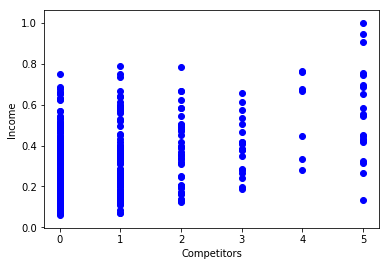

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(merged2.Competitors, merged2.Income,  color='blue')
plt.xlabel("Competitors")
plt.ylabel("Income")
plt.show()

Then we split the dataframe into training and testing sets, and perform the linear regression model fitting.

In [61]:
msk = np.random.rand(len(merged2)) < 0.8
train = merged2[msk]
test = merged2[~msk]

In [62]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
train_x = np.asanyarray(train[['Competitors']])
train_y = np.asanyarray(train[['Income']])
regr.fit (train_x, train_y)
# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Intercept: ',regr.intercept_)

Coefficients:  [[0.05878356]]
Intercept:  [0.25197133]


As we can see from the plot there appears to be some degree of positive correlation with area income for this venue type, although the margin of error is large and this model as such would probably not be very useful for predicting future values.

Text(0, 0.5, 'Income')

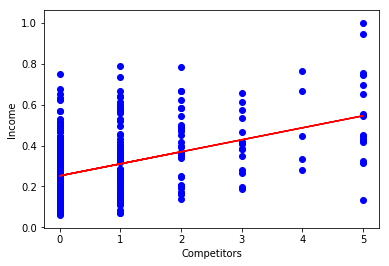

In [63]:
plt.scatter(train.Competitors, train.Income,  color='blue')
plt.plot(train_x, regr.coef_[0][0]*train_x + regr.intercept_[0], '-r')
plt.xlabel("Competitors")
plt.ylabel("Income")

<h2>7. Cluster income and competitor data</h2> <a name="cluster"></a>

Finally the income and competitor data will be clustered, in order to display general areas for locations. The outliers identified previously may be true outliers outside the optimal areas, as opposed to potential market niche locations inside the general optimal areas. 

For this analysis, we will first invert the competitor count data to make it comparable with the income data. Now a high value in the Competitors column signifies a low amount of competing venues, and vice versa.

In [64]:
merged2['Competitors'] = 1/(merged2['Competitors']+1)

merged2.head()

,Income,Competitors,Latitude_x,Longitude_x,Neighborhood,Radius
0,0.248473,0.333333,41.739990,-87.631713,Census Tract 8424,1.463580
1,0.286334,1,41.830013,-87.681365,Census Tract 8403,1.015948
2,0.170350,0.5,41.851635,-87.636554,Census Tract 8411,1.029284
3,0.202497,1,41.855687,-87.683255,Census Tract 8412,0.658152
4,0.531260,0.5,41.870959,-87.631697,Census Tract 8390,0.602525


We will use DBSCAN for the clustering of the optimal areas, as it can handle arbitrarily shaped clusters. The parameters were determined experimentally.

In [77]:
from sklearn.cluster import DBSCAN 
from sklearn.datasets.samples_generator import make_blobs 
from sklearn.preprocessing import StandardScaler


X = merged2[['Income','Competitors']]

epsilon = 0.1
minimumSamples = 3
db = DBSCAN(eps=epsilon, min_samples=minimumSamples).fit(X)
labels = db.labels_
labels

array([0, 1, 2, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 0, 2,
       1, 0, 2, 1, 1, 2, 0, 0, 1, 1, 0, 0, 2, 0, 2, 0, 0, 0, 1, 0, 1, 1,
       1, 2, 2, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 0, 0, 0, 0, 2, 1, 2, 1, 0,
       0, 0, 0, 1, 1, 0, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 0, 0, 2, 2, 0, 1,
       1, 0, 0, 0, 0, 2, 2, 1, 1, 0, 2, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 0, 0, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 0, 2, 1, 2, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 2, 2, 0, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 2, 2, 1, 1, 0, 2, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 2, 1, 2, 0, 2, 0, 2, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 2, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 2, 1, 0, 1, 2,

Displaying the clusters and examining the values, we find three clusters have been generated with blue for high income and good competition values, yellow high income and poor competition values (indicating more competing venues after inversion), and green low income and excellent competition values. 

In [79]:
# create map of Chicago using latitude and longitude values
map_merged = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, income, compet, cluster in zip(merged2['Latitude_x'], merged2['Longitude_x'], merged2['Income'],merged2['Competitors'],labels):
    label = '{} {}'.format(income, compet)
    label = folium.Popup(label, parse_html=True)
    if cluster == -1:
        fill_color = 'red'
    elif cluster == 0:
        fill_color = 'orange'
    elif cluster == 1:
        fill_color = 'green'
    else:
        fill_color = 'blue'
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=fill_color,
        fill=True,
        fill_color=fill_color,
        fill_opacity=0.7,
        parse_html=False).add_to(map_merged)  
    
map_merged

Concluding the analysis, it would appear the outlier we saw earlier in the south of the Lincoln Park area is actually a relatively low income area, which is to be avoided in this approach. However the areas in the northern parts, around Lakeview remain viable locations. We have also identified more location candidates on the outskirts of the premium areas. However other points have been somewhat mislabeled as optimal in the generally lower icome areas, simply because they have some competition. Better approaches are explored in the project report.